In [1]:
import sys
sys.path.append('..')
import os
import joblib
from scipy.io import arff
import pandas as pd
from sklearn import preprocessing
from sklearn.impute import KNNImputer
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import cross_val_score
from xgboost import XGBClassifier
import torch
import torch_explain as te
from torch.nn.functional import one_hot
from torch_explain.logic.nn import entropy
from torch_explain.logic.metrics import test_explanation, complexity
from sklearn.metrics import f1_score, accuracy_score
from sklearn.model_selection import StratifiedShuffleSplit
import torch.nn as nn
from torch_geometric.data import Data
from torch_geometric.nn import GCNConv, Sequential
from torch_geometric.utils.convert import from_networkx
from torch_geometric.utils import to_undirected, add_remaining_self_loops
import numpy as np
import seaborn as sns
import networkx as nx
from torch.nn.functional import one_hot, leaky_relu

In [2]:
data = arff.loadarff('../data/MiceProtein.arff')
df = pd.DataFrame(data[0])
df.head()

,MouseID,DYRK1A_N,ITSN1_N,BDNF_N,NR1_N,NR2A_N,pAKT_N,pBRAF_N,pCAMKII_N,pCREB_N,...,pCFOS_N,SYP_N,H3AcK18_N,EGR1_N,H3MeK4_N,CaNA_N,Genotype,Treatment,Behavior,class
0,b'309_1',0.503644,0.747193,0.430175,2.816329,5.990152,0.218830,0.177565,2.373744,0.232224,...,0.108336,0.427099,0.114783,0.131790,0.128186,1.675652,b'Control',b'Memantine',b'C/S',b'c-CS-m'
1,b'309_2',0.514617,0.689064,0.411770,2.789514,5.685038,0.211636,0.172817,2.292150,0.226972,...,0.104315,0.441581,0.111974,0.135103,0.131119,1.743610,b'Control',b'Memantine',b'C/S',b'c-CS-m'
2,b'309_3',0.509183,0.730247,0.418309,2.687201,5.622059,0.209011,0.175722,2.283337,0.230247,...,0.106219,0.435777,0.111883,0.133362,0.127431,1.926427,b'Control',b'Memantine',b'C/S',b'c-CS-m'
3,b'309_4',0.442107,0.617076,0.358626,2.466947,4.979503,0.222886,0.176463,2.152301,0.207004,...,0.111262,0.391691,0.130405,0.147444,0.146901,1.700563,b'Control',b'Memantine',b'C/S',b'c-CS-m'
4,b'309_5',0.434940,0.617430,0.358802,2.365785,4.718679,0.213106,0.173627,2.134014,0.192158,...,0.110694,0.434154,0.118481,0.140314,0.148380,1.839730,b'Control',b'Memantine',b'C/S',b'c-CS-m'


In [3]:
is_control = df['Genotype'] == b'Control'
imputer = KNNImputer()
x = imputer.fit_transform(df.iloc[:, 1:-4])
control_signature = x[is_control].mean(axis=0)
x = x - control_signature
x = torch.FloatTensor(x)

le = preprocessing.LabelEncoder()
y = le.fit_transform(df.iloc[:, -1])
y = torch.LongTensor(y)
print(x.shape, y.shape, is_control.shape)

torch.Size([1080, 77]) torch.Size([1080]) (1080,)


In [4]:
le.classes_

array([b'c-CS-m', b'c-CS-s', b'c-SC-m', b'c-SC-s', b't-CS-m', b't-CS-s',
       b't-SC-m', b't-SC-s'], dtype=object)

8407.0

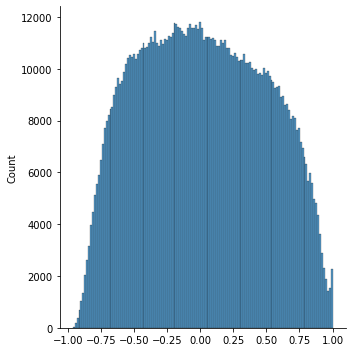

In [5]:
C = np.corrcoef(x)
sns.displot(C.ravel())
C_abs = np.abs(C)>0.9
C_abs.sum()/2

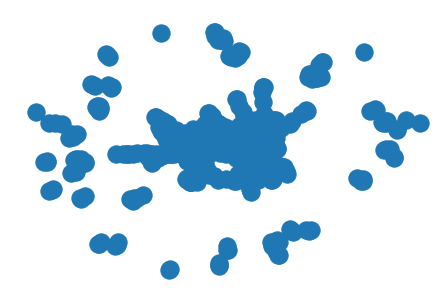

In [6]:
G = nx.from_numpy_matrix(C_abs)
G.remove_edges_from(nx.selfloop_edges(G))
nx.draw(G)

In [7]:
edges = from_networkx(G).edge_index
edges

tensor([[   0,    0,    0,  ..., 1079, 1079, 1079],
        [   1,    2,   34,  ..., 1076, 1077, 1078]])

In [8]:
print(edges.shape)
# edges = add_remaining_self_loops(edges)[0]
# print(edges.shape)
edges = to_undirected(edges)
print(edges.shape)

torch.Size([2, 15734])
torch.Size([2, 15734])


In [25]:
class GCN(nn.Module):
    def __init__(self, num_in_features, num_hidden_features, num_classes):
        super(GCN, self).__init__()
        self.num_classes = num_classes

#         self.conv0 = GCNConv(num_hidden_features, num_hidden_features)
#         self.conv1 = GCNConv(num_hidden_features, 1)

        # linear layers
        self.lens = te.nn.EntropyLinear(num_in_features, num_hidden_features, n_classes=num_classes, temperature=1)
        self.linear = nn.Linear(num_hidden_features, 1)

    def forward(self, x, edge_index):
        x = self.lens(x)
        x = leaky_relu(x)
        x = self.linear(x)

#         preds = []
#         for nc in range(self.num_classes):
#             xc = self.conv0(x[:, nc], edge_index)
#             xc = leaky_relu(xc)

#             xc = self.conv1(xc, edge_index)
#             xc = leaky_relu(xc)
#             preds.append(xc)

#         preds = torch.hstack(preds)
        return x

def train_lens(x, y, edges, train_index):
    model = GCN(x.shape[1], 50, len(torch.unique(y)))
    optimizer = torch.optim.AdamW(model.parameters(), lr=0.001)
    loss_form = torch.nn.CrossEntropyLoss()
    model.train()
    for epoch in range(10001):
        optimizer.zero_grad()
        y_pred = model(x, edges).squeeze(-1)
        loss = loss_form(y_pred[train_index], y[train_index]) #+ 0.0001 * te.nn.functional.entropy_logic_loss(model)
        loss.backward()
        optimizer.step()
        if epoch % 500 == 0:
            print(f'Epoch {epoch}: {loss}')
        
    model.eval()
    return model
    
def test_lens(model, x, y1h, edges, train_index, test_index):
    y_pred = model(x, edges).squeeze(-1).detach()
    f1 = f1_score(y1h[test_index].argmax(dim=-1), y_pred[test_index].argmax(dim=-1), average='weighted')
    acc = accuracy_score(y1h[test_index].argmax(dim=-1), y_pred[test_index].argmax(dim=-1))
    print(f'Test F1: {f1}')
    explanations = entropy.explain_classes(model, x, y1h, train_index, test_index, edge_index=edges, 
#                                            c_threshold=0., y_threshold=0, topk_explanations=500, 
#                                            max_minterm_complexity=3)
                                           c_threshold=0., y_threshold=0, topk_explanations=100, 
                                           max_minterm_complexity=10)
    for nc in range(y1h.shape[1]):
        explanations[f'{nc}']['explanation'] = te.logic.utils.replace_names(explanations[f'{nc}']['explanation'], df.columns[1:-4])
        explanations[f'{nc}']['name'] = le.classes_[nc]
        
    explanations['accuracy'] = acc
    explanations['f1'] = f1
    return explanations

In [27]:
from sklearn.linear_model import RidgeClassifier
from meco import MECO

meco = MECO(RidgeClassifier(random_state=42), compression='features', max_features=10, max_generations=100)
meco.fit(x[train_index], y[train_index])

[0:00:00s] Generation 0, Best individual: #features=10 (of 77), accuracy=56.82, test=46.77
[0:00:00s] Generation 1, Best individual: #features=10 (of 77), accuracy=54.02, test=52.05
[0:00:00s] Generation 2, Best individual: #features=10 (of 77), accuracy=52.27, test=56.90
[0:00:00s] Generation 3, Best individual: #features=10 (of 77), accuracy=54.55, test=70.55
[0:00:00s] Generation 4, Best individual: #features=10 (of 77), accuracy=53.41, test=71.91
[0:00:00s] Generation 5, Best individual: #features=10 (of 77), accuracy=56.82, test=71.91
[0:00:00s] Generation 6, Best individual: #features=10 (of 77), accuracy=62.50, test=79.50
[0:00:00s] Generation 7, Best individual: #features=10 (of 77), accuracy=62.50, test=79.50
[0:00:00s] Generation 8, Best individual: #features=10 (of 77), accuracy=62.50, test=79.50
[0:00:00s] Generation 9, Best individual: #features=10 (of 77), accuracy=63.64, test=79.50
[0:00:00s] Generation 10, Best individual: #features=10 (of 77), accuracy=52.27, test=84.7

[0:00:00s] Generation 89, Best individual: #features=9 (of 77), accuracy=56.82, test=119.13
[0:00:00s] Generation 90, Best individual: #features=9 (of 77), accuracy=56.82, test=119.13
[0:00:00s] Generation 91, Best individual: #features=9 (of 77), accuracy=56.82, test=119.13
[0:00:00s] Generation 92, Best individual: #features=9 (of 77), accuracy=56.82, test=119.13
[0:00:00s] Generation 93, Best individual: #features=9 (of 77), accuracy=56.82, test=119.13
[0:00:00s] Generation 94, Best individual: #features=9 (of 77), accuracy=56.82, test=119.13
[0:00:00s] Generation 95, Best individual: #features=9 (of 77), accuracy=56.82, test=119.13
[0:00:00s] Generation 96, Best individual: #features=9 (of 77), accuracy=56.82, test=119.13
[0:00:00s] Generation 97, Best individual: #features=9 (of 77), accuracy=56.82, test=119.13
[0:00:00s] Generation 98, Best individual: #features=9 (of 77), accuracy=56.82, test=119.13
[0:00:00s] Generation 99, Best individual: #features=9 (of 77), accuracy=56.82, 

MECO(compression='features', estimator=RidgeClassifier(random_state=42),
     max_features=10)

In [28]:
x1 = meco.transform(x.numpy())
x1 = torch.FloatTensor(x1)

In [29]:
clf = RandomForestClassifier()
cross_val_score(clf, x1[train_index], y[train_index])

array([0.94871795, 0.94871795, 0.93298969, 0.91752577, 0.90721649])

In [26]:
sss = StratifiedShuffleSplit(n_splits=10, test_size=0.1, random_state=0)
sss.get_n_splits(x1, y)
y1h = one_hot(torch.LongTensor(y)).float()

os.makedirs('./results/miceProtein/', exist_ok=True)
fold = 0
results = {}
dt_node_count = []
for train_index, test_index in sss.split(x1, y):
    
    clf1 = RandomForestClassifier(random_state=0)
    clf1.fit(x1[train_index], y[train_index])
    y_pred = clf1.predict(x1[test_index])
    f1_rf = f1_score(y[test_index], y_pred, average='weighted')
    print(f'Test F1 (RF): {f1_rf}')
    
    clf = DecisionTreeClassifier(random_state=0)
    clf.fit(x1[train_index], y[train_index])
    y_pred = clf.predict(x1[test_index])
    f1_dt = f1_score(y[test_index], y_pred, average='weighted')
    print(f'Test F1 (DT): {f1_dt}')
    dt_node_count.append(clf.tree_.node_count)
    
    model = train_lens(x1, y, edges, train_index)
    explanations = test_lens(model, x1, y1h, edges, train_index, test_index)
    
    results[fold] = {
        'RF': f1_rf,
        'DT': f1_dt,
        'LEN': explanations,
    }
    joblib.dump(results, os.path.join(f'./results/miceProtein/results.joblib'))
    fold += 1

Test F1 (RF): 0.9442188497594709
Test F1 (DT): 0.7928549503584565
Epoch 0: 2.0774741172790527
Epoch 500: 0.9558737277984619
Epoch 1000: 0.6793226003646851
Epoch 1500: 0.5232000946998596
Epoch 2000: 0.417275995016098
Epoch 2500: 0.34220001101493835
Epoch 3000: 0.28279826045036316
Epoch 3500: 0.2402193397283554
Epoch 4000: 0.20541071891784668
Epoch 4500: 0.17633949220180511
Epoch 5000: 0.15274308621883392
Epoch 5500: 0.1325518637895584
Epoch 6000: 0.11645850539207458
Epoch 6500: 0.10078546404838562
Epoch 7000: 0.08854865282773972
Epoch 7500: 0.07799182087182999
Epoch 8000: 0.0676451027393341
Epoch 8500: 0.060021232813596725
Epoch 9000: 0.05329067260026932
Epoch 9500: 0.04747806489467621
Epoch 10000: 0.04288532957434654
Test F1: 0.9628747795414462
Explanation class 0: (feature0000000004 & feature0000000009 & ~feature0000000003) | (feature0000000008 & feature0000000009 & ~feature0000000003) - acc. = 0.6939 - compl. = 6.0000
Explanation class 1: (~feature0000000002 & ~feature0000000003 & ~f

KeyboardInterrupt: 

In [34]:
s

<Individual: candidate = [[], [30, 32, 34, 38, 42, 53, 63, 65, 70, 76]], fitness = [67, 0.7931034482758621, 114.92702789209102], birthdate = 1655550621.6954398>

In [36]:
for s in meco.solutions_:
    print(list(df.columns[1:-4][s.candidate[1]]))

['APP_N', 'SOD1_N', 'P38_N', 'NR2B_N', 'pP70S6_N', 'ARC_N', 'PSD95_N', 'Ubiquitin_N', 'pS6_N', 'CaNA_N']
['JNK_N', 'APP_N', 'SOD1_N', 'P38_N', 'pP70S6_N', 'ARC_N', 'Ubiquitin_N', 'pS6_N', 'CaNA_N']
['APP_N', 'SOD1_N', 'P38_N', 'pP70S6_N', 'nNOS_N', 'pCASP9_N', 'PSD95_N', 'Ubiquitin_N', 'pS6_N', 'CaNA_N']
['NR1_N', 'NR2A_N', 'APP_N', 'SOD1_N', 'P38_N', 'NR2B_N', 'pP70S6_N', 'Ubiquitin_N', 'pS6_N', 'CaNA_N']
['pPKCAB_N', 'APP_N', 'SOD1_N', 'pMTOR_N', 'pNUMB_N', 'pP70S6_N', 'GluR4_N', 'SNCA_N', 'Ubiquitin_N', 'CaNA_N']
['pNR2A_N', 'pPKCAB_N', 'APP_N', 'pNUMB_N', 'RAPTOR_N', 'pP70S6_N', 'pPKCG_N', 'Ubiquitin_N', 'SYP_N', 'CaNA_N']


In [85]:
df_heat = pd.DataFrame(model.lens.alpha_norm.detach().numpy(), columns=df.columns[1:-4], index=le.classes_)
df_heat.head()

,DYRK1A_N,ITSN1_N,BDNF_N,NR1_N,NR2A_N,pAKT_N,pBRAF_N,pCAMKII_N,pCREB_N,pELK_N,...,SHH_N,BAD_N,BCL2_N,pS6_N,pCFOS_N,SYP_N,H3AcK18_N,EGR1_N,H3MeK4_N,CaNA_N
b'c-CS-m',9.984314e-01,9.832391e-01,1.398318e-07,9.042333e-01,0.909079,3.945889e-06,1.823627e-01,0.997499,2.153024e-07,9.964814e-01,...,6.303098e-06,4.610987e-01,0.000008,2.772627e-06,4.629448e-06,9.011058e-07,3.929430e-07,1.302499e-07,1.669515e-07,2.540148e-06
b'c-CS-s',4.640019e-07,2.065119e-06,8.962381e-06,3.963984e-06,0.000001,1.832425e-07,6.802823e-07,0.997463,7.208236e-04,9.851012e-01,...,3.093234e-07,1.609138e-05,0.000008,1.419002e-06,2.342049e-05,7.237878e-02,4.701430e-06,4.445086e-06,1.129766e-07,1.595647e-06
b'c-SC-m',1.000000e+00,6.007937e-07,2.088987e-07,2.481939e-07,0.000136,6.720609e-06,6.040212e-08,0.588615,3.326711e-06,2.768239e-07,...,5.897615e-08,2.937411e-07,0.000017,7.448540e-08,9.037606e-08,9.976224e-01,6.253938e-01,6.694670e-06,5.196148e-06,6.392204e-07
b'c-SC-s',1.021531e-05,9.909252e-01,3.799691e-04,6.948362e-06,0.798553,1.171002e-04,6.366641e-05,0.930643,4.441806e-05,9.918215e-01,...,3.828733e-06,2.479131e-04,0.000010,5.058339e-06,1.536579e-05,2.824267e-06,6.374826e-04,5.548507e-05,3.549873e-05,3.852855e-06
b't-CS-m',9.828716e-01,7.251914e-01,3.051466e-03,1.222699e-05,0.477240,2.544319e-06,5.289090e-06,0.032534,6.539392e-06,1.861432e-05,...,2.305226e-06,9.637884e-06,0.000005,3.824305e-01,4.009557e-06,1.030593e-07,1.908968e-07,1.084289e-04,9.930687e-07,1.000000e+00


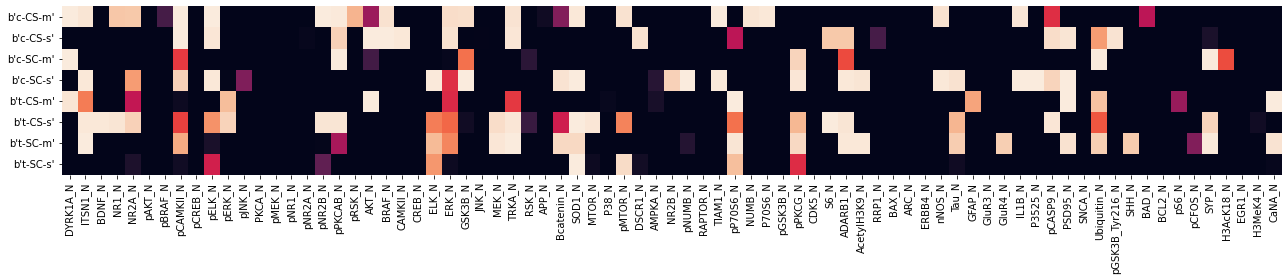

In [92]:
import matplotlib.pyplot as plt
plt.figure(figsize=[18, 4])
sns.heatmap(df_heat, cbar=False)
plt.tight_layout()
plt.savefig('./results/miceProtein/heatmap.png')
plt.savefig('./results/miceProtein/heatmap.pdf')

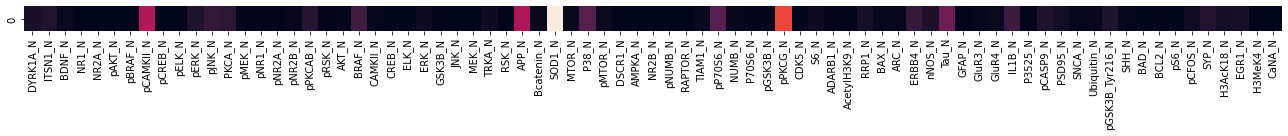

In [140]:
dt_heat = pd.DataFrame(clf.feature_importances_[np.newaxis], columns=df.columns[1:-4])
plt.figure(figsize=[18, 2])
sns.heatmap(dt_heat, cbar=False)
plt.tight_layout()
plt.savefig('./results/miceProtein/heatmap_dt.png')
plt.savefig('./results/miceProtein/heatmap_dt.pdf')

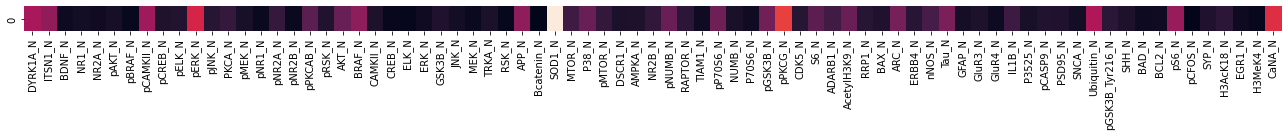

In [142]:
dt_heat = pd.DataFrame(clf1.feature_importances_[np.newaxis], columns=df.columns[1:-4])
plt.figure(figsize=[18, 2])
sns.heatmap(dt_heat, cbar=False)
plt.tight_layout()
plt.savefig('./results/miceProtein/heatmap_rf.png')
plt.savefig('./results/miceProtein/heatmap_rf.pdf')

In [134]:
accs = {'RF': [], 'DT': [], 'DT Complexity': [], 'LEN': [], 'Logic': [], 'Logic Complexity': []}
for key, item in results.items():
    accs['RF'].append(item['RF'])
    accs['DT'].append(item['DT'])
    accs['DT Complexity'].append(dt_node_count[key])
    accs['LEN'].append(item['LEN']['f1'])
    accs['Logic'].append(np.mean([item['LEN'][f'{i}']['explanation_accuracy'] for i in range(8)]))
    accs['Logic Complexity'].append(np.mean([item['LEN'][f'{i}']['explanation_complexity'] for i in range(8)]))
    
accs = pd.DataFrame(accs)
accs.to_csv(f'./results/miceProtein/metrics.csv')
accs

,RF,DT,DT Complexity,LEN,Logic,Logic Complexity
0,0.990741,0.865325,163,1.000000,0.729521,4.500
1,0.981493,0.905348,163,0.972186,0.701859,5.250
2,0.990719,0.860945,169,1.000000,0.736519,5.000
3,1.000000,0.881515,163,0.990715,0.745735,7.125
4,0.990741,0.849732,157,1.000000,0.718506,5.250
5,1.000000,0.915677,163,0.990719,0.716084,4.000
6,0.990741,0.839660,177,1.000000,0.721509,9.000
7,0.990741,0.877767,165,0.990719,0.723787,4.625
8,1.000000,0.842708,179,0.990705,0.738364,5.250
9,0.981437,0.850691,159,0.981289,0.753942,5.500


In [135]:
for col in accs.columns:
    print(f'{col}: {accs[col].mean()} +- {accs[col].sem()}')

RF: 0.9916612275446166 +- 0.0021622944320423853
DT: 0.8689367547119178 +- 0.008212751181757268
DT Complexity: 165.8 +- 2.27449628123093
LEN: 0.9916332288314557 +- 0.0029222912195790824
Logic: 0.7285824594120317 +- 0.004878309967783159
Logic Complexity: 5.55 +- 0.4633063541305879


In [143]:
results = joblib.load(os.path.join(f'./results/miceProtein/results.joblib'))
results

{0: {'RF': 0.9907407407407407,
  'DT': 0.8653248534730017,
  'LEN': {'0': {'explanation': 'NR2A_N & BRAF_N & MTOR_N',
    'explanation_accuracy': 0.6939271255060729,
    'explanation_complexity': 3,
    'name': b'c-CS-m'},
   '1': {'explanation': '(pPKCAB_N & ~pCAMKII_N & ~SOD1_N & ~Ubiquitin_N) | (CAMKII_N & ~SOD1_N & ~pCASP9_N & ~Ubiquitin_N)',
    'explanation_accuracy': 0.7227842367507171,
    'explanation_complexity': 8,
    'name': b'c-CS-s'},
   '2': {'explanation': 'pCAMKII_N & pNR2A_N & Ubiquitin_N & ~DYRK1A_N & ~ADARB1_N & ~CaNA_N',
    'explanation_accuracy': 0.7813765182186234,
    'explanation_complexity': 6,
    'name': b'c-SC-m'},
   '3': {'explanation': '~ITSN1_N & ~pNUMB_N & ~pPKCG_N',
    'explanation_accuracy': 0.841675392670157,
    'explanation_complexity': 3,
    'name': b'c-SC-s'},
   '4': {'explanation': '(pERK_N & ~ERK_N) | (pERK_N & BRAF_N & APP_N & CaNA_N & ~pJNK_N)',
    'explanation_accuracy': 0.7666666666666667,
    'explanation_complexity': 7,
    'name':